# Assignment: Trees

## Do two questions in total: "Q1+Q2" or "Q1+Q3"

`! git clone https://github.com/ds3001f25/linear_models_assignment.git`

**Q1.** Please answer the following questions in your own words.
1. Why is the Gini a good loss function for categorical target variables?
2. Why do trees tend to overfit, and how can this tendency be constrained?
3. True or false, and explain: Trees only really perform well in situations with lots of categorical variables as features/covariates.
4. Why don't most versions of classification/regression tree concept allow for more than two branches after a split?
5. What are some heuristic ways you can examine a tree and decide whether it is probably over- or under-fitting?

### **Q1. Answers**
1. The Gini impurity measures how often a randomly chosen sample would be incorrectly labeled if it were randomly labeled according to the class distribution in a node. It is good for categorical targets because it captures class mixing, and it is differentiable and efficient.


2. Trees overfit because they can keep splitting until each leaf is pure, capturing not just patterns but also noise in the data.
They can have high variance. We can constrain overfitting by limiting tree depth, requiring a minimum number of samples per split or leaf, or clean up and prune after tree growth.

3. **False.** Decision trees can handle both categorical and continuous variables well. They perform well with nonlinear relationships and mixed data types.

4. Binary splits are preferred because they keep computations simple and allow for balanced trees. This can allow for better recursive optimization.

5. Heuristic checks:

* Overfitting signs:

  * Very deep tree with many leaves.
  * Many leaves have few samples.
  * Complex structure that’s hard to interpret.

* Underfitting signs:

  * Very shallow tree (few levels).
  * Poor training accuracy (fails to capture patterns).
  * Simple splits that don’t separate classes meaningfully.


  ---

**Q2.** This is a case study about classification and regression trees.

1. Load the `Breast Cancer METABRIC.csv` dataset. How many observations and variables does it contain? Print out the first few rows of data.

2.  We'll use a consistent set of feature/explanatory variables. For numeric variables, we'll include `Tumor Size`, `Lymph nodes examined positive`, `Age at Diagnosis`. For categorical variables, we'll include `Tumor Stage`, `Chemotherapy`, and `Cancer Type Detailed`. One-hot-encode the categorical variables and concatenate them with the numeric variables into a feature/covariate matrix, $X$.

3. Let's predict `Overall Survival Status` given the features/covariates $X$. There are 528 missing values, unfortunately: Either drop those rows from your data or add them as a category to predict. Constrain the minimum samples per leaf to 10. Print a dendrogram of the tree. Print a confusion matrix of the algorithm's performance. What is the accuracy?

4. For your model in part three, compute three statistics:
    - The **true positive rate** or **sensitivity**:
        $$
        TPR = \dfrac{TP}{TP+FN}
        $$
    - The **true negative rate** or **specificity**:
        $$
        TNR = \dfrac{TN}{TN+FP}
        $$
    Does your model tend to perform better with respect to one of these metrics?

5. Let's predict `Overall Survival (Months)` given the features/covariates $X$. Use the train/test split to pick the optimal `min_samples_leaf` value that gives the highest $R^2$ on the test set (it's about 110). What is the $R^2$? Plot the test values against the predicted values. How do you feel about this model for clinical purposes?

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

bc = pd.read_csv('/content/Breast Cancer METABRIC.csv')
bc.head()

#pt 1
print(bc.shape)
bc.head()
#there are 2509 observations and 34 variables


(2509, 34)


,Patient ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,...,Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status (Months),Relapse Free Status,Sex,3-Gene classifier subtype,Tumor Size,Tumor Stage,Patient's Vital Status
0,MB-0000,75.65,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,No,claudin-low,1.0,Positve,...,Living,Negative,Yes,138.65,Not Recurred,Female,ER-/HER2-,22.0,2.0,Living
1,MB-0002,43.19,Breast Conserving,Breast Cancer,Breast Invasive Ductal Carcinoma,High,No,LumA,1.0,Positve,...,Living,Positive,Yes,83.52,Not Recurred,Female,ER+/HER2- High Prolif,10.0,1.0,Living
2,MB-0005,48.87,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,High,Yes,LumB,1.0,Positve,...,Deceased,Positive,No,151.28,Recurred,Female,NaN,15.0,2.0,Died of Disease
3,MB-0006,47.68,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,Yes,LumB,1.0,Positve,...,Living,Positive,Yes,162.76,Not Recurred,Female,NaN,25.0,2.0,Living
4,MB-0008,76.97,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,Yes,LumB,1.0,Positve,...,Deceased,Positive,Yes,18.55,Recurred,Female,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


Optimal min_samples_leaf: 128
Best R^2 on the test set: 0.0984

R^2 on the test set with optimal min_samples_leaf (128): 0.0984


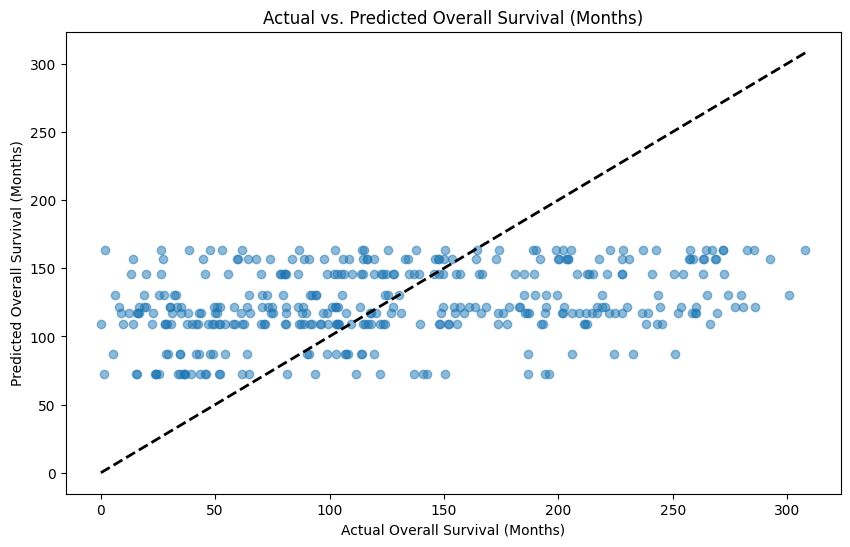


Discussion for clinical purposes:
The R^2 value of 0.0984 indicates that the model explains approximately 9.84% of the variance in Overall Survival (Months) on the test set.
The scatter plot shows the relationship between actual and predicted values.
For clinical purposes, an R^2 of this magnitude might be considered modest.
A perfect model would have all points lying on the diagonal line.
Deviations from the line indicate prediction errors.
Factors to consider for clinical use:
- The R^2 value and the scatter plot suggest the model has some predictive capability, but there is significant variability in the predictions.
- Errors in survival prediction can have serious implications for treatment planning and patient counseling.
- While the model captures some patterns, it may not be sufficiently accurate or reliable for making critical individual patient decisions without further validation and consideration of other clinical factors.
- The interpretability of the decision tree structu

In [8]:
# pt 5

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

# Prepare the target variable for regression
y_reg = bc['Overall Survival (Months)']

# Combine X and y_reg to drop rows with missing values
data_reg = pd.concat([X, y_reg], axis=1)
data_reg.dropna(inplace=True)

# Separate X and y_reg again
X_cleaned_reg = data_reg.drop('Overall Survival (Months)', axis=1)
y_cleaned_reg = data_reg['Overall Survival (Months)']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_cleaned_reg, y_cleaned_reg, test_size=0.2, random_state=42)

# Find optimal min_samples_leaf
best_r2 = -float('inf')
best_min_samples_leaf = 0

# Iterate through possible values of min_samples_leaf
# Based on the prompt, the optimal value is around 110, so we can search around that.
# Let's check a range around 110, e.g., from 100 to 130.
for min_leaf in range(100, 131):
    dt_regressor = DecisionTreeRegressor(min_samples_leaf=min_leaf, random_state=42)
    dt_regressor.fit(X_train, y_train)
    y_pred_test = dt_regressor.predict(X_test)
    r2 = r2_score(y_test, y_pred_test)

    if r2 > best_r2:
        best_r2 = r2
        best_min_samples_leaf = min_leaf

print(f"Optimal min_samples_leaf: {best_min_samples_leaf}")
print(f"Best R^2 on the test set: {best_r2:.4f}")

# Train the final model with the optimal min_samples_leaf on the entire cleaned data
# Alternatively, train on the full training set for the final model, but for demonstrating R^2 on test,
# we already have the best value. Let's use the best found value on the test set.
# For the final R^2 on the test set, we use the model trained with the best_min_samples_leaf
final_dt_regressor = DecisionTreeRegressor(min_samples_leaf=best_min_samples_leaf, random_state=42)
final_dt_regressor.fit(X_train, y_train)
y_test_pred_final = final_dt_regressor.predict(X_test)
final_r2 = r2_score(y_test, y_test_pred_final)

print(f"\nR^2 on the test set with optimal min_samples_leaf ({best_min_samples_leaf}): {final_r2:.4f}")

# Plot test values against predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_final, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Ideal prediction line
plt.xlabel("Actual Overall Survival (Months)")
plt.ylabel("Predicted Overall Survival (Months)")
plt.title("Actual vs. Predicted Overall Survival (Months)")
plt.show()

# Discussion on clinical purposes
print("\nDiscussion for clinical purposes:")
print(f"The R^2 value of {final_r2:.4f} indicates that the model explains approximately {final_r2*100:.2f}% of the variance in Overall Survival (Months) on the test set.")
print("The scatter plot shows the relationship between actual and predicted values.")
print("For clinical purposes, an R^2 of this magnitude might be considered modest.")
print("A perfect model would have all points lying on the diagonal line.")
print("Deviations from the line indicate prediction errors.")
print("Factors to consider for clinical use:")
print("- The R^2 value and the scatter plot suggest the model has some predictive capability, but there is significant variability in the predictions.")
print("- Errors in survival prediction can have serious implications for treatment planning and patient counseling.")
print("- While the model captures some patterns, it may not be sufficiently accurate or reliable for making critical individual patient decisions without further validation and consideration of other clinical factors.")
print("- The interpretability of the decision tree structure could be a benefit, allowing clinicians to understand the factors influencing predictions for specific patients.")
print("- Further evaluation with additional metrics (e.g., Mean Absolute Error, Root Mean Squared Error), validation on independent datasets, and comparison with established clinical prognostic tools would be necessary before considering this model for clinical application.")

In [7]:
# pt 4

# Calculate True Positive Rate (Sensitivity) and True Negative Rate (Specificity)

# From the confusion matrix:
# [[TN, FP],
#  [FN, TP]]

TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]

tpr = TP / (TP + FN)
tnr = TN / (TN + FP)

print(f"\nTrue Positive Rate (Sensitivity): {tpr:.4f}")
print(f"True Negative Rate (Specificity): {tnr:.4f}")

# Interpretation
if tpr > tnr:
    print("\nThe model performs better with respect to True Positive Rate (Sensitivity).")
elif tnr > tpr:
    print("\nThe model performs better with respect to True Negative Rate (Specificity).")
else:
    print("\nThe model performs equally well with respect to True Positive Rate and True Negative Rate.")


True Positive Rate (Sensitivity): 0.6776
True Negative Rate (Specificity): 0.8332

The model performs better with respect to True Negative Rate (Specificity).


Confusion Matrix:
[[909 182]
 [256 538]]

Accuracy: 0.7676392572944297


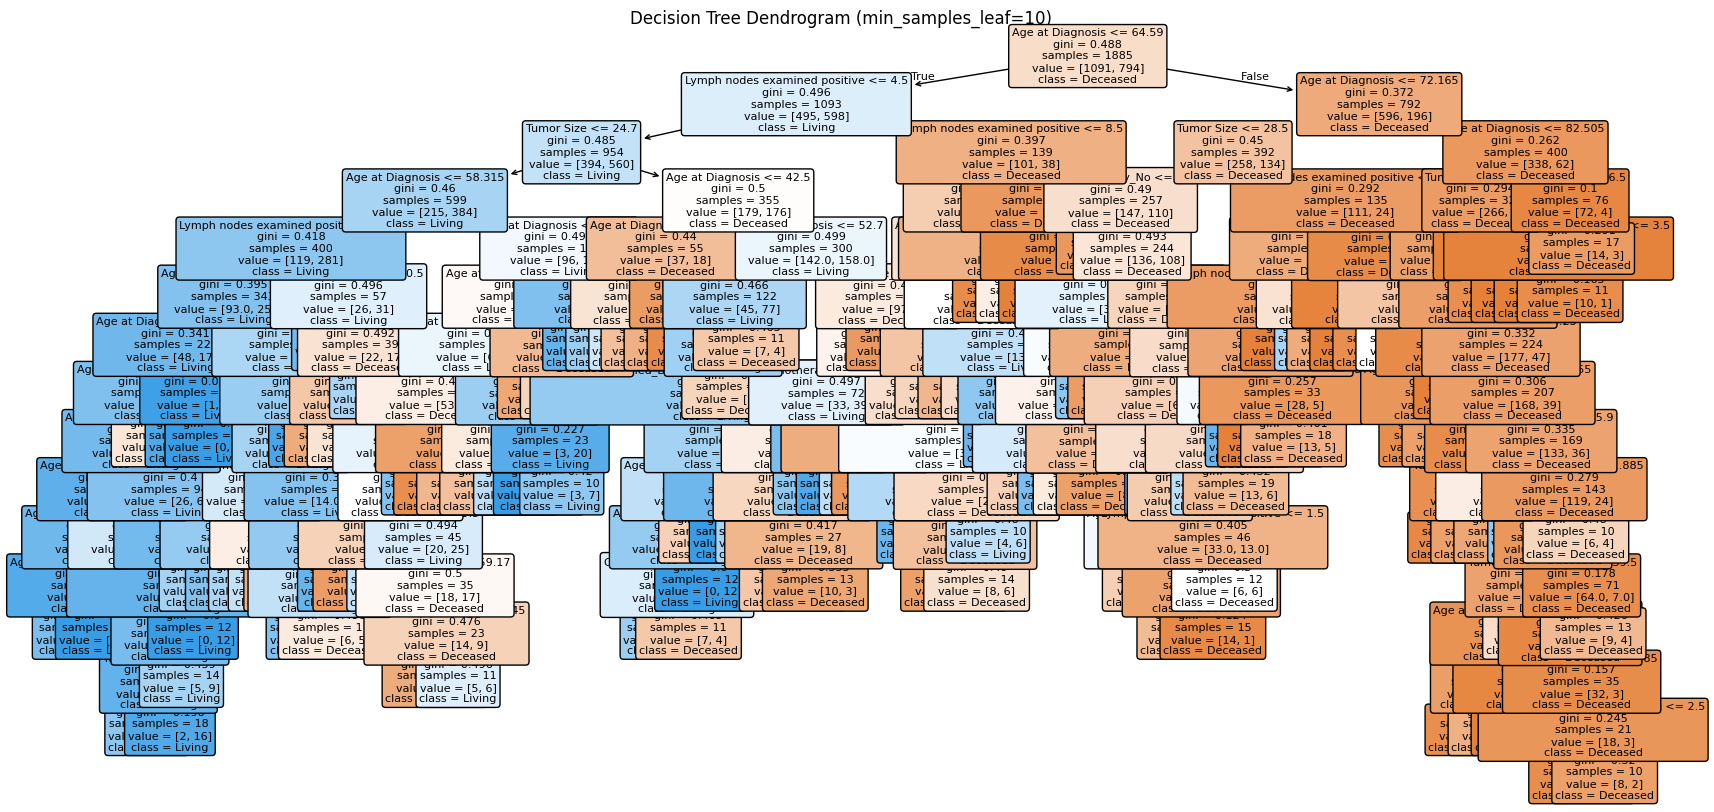

In [6]:
# pt 3

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Prepare the target variable
y = bc['Overall Survival Status']

# Combine X and y to drop rows with missing values in either
data = pd.concat([X, y], axis=1)
data.dropna(inplace=True)

# Separate X and y again
X_cleaned = data.drop('Overall Survival Status', axis=1)
y_cleaned = data['Overall Survival Status']

# Split data (optional, but good practice)
# X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

# Train a Decision Tree Classifier
# Using the cleaned data and the constraint min_samples_leaf=10
dt_classifier = DecisionTreeClassifier(min_samples_leaf=10, random_state=42)
dt_classifier.fit(X_cleaned, y_cleaned) # Using all cleaned data for demonstration as no train/test split was explicitly asked for prediction in pt 3

# Predict on the same data used for training
y_pred = dt_classifier.predict(X_cleaned)

# Print confusion matrix
conf_matrix = confusion_matrix(y_cleaned, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Print accuracy
accuracy = accuracy_score(y_cleaned, y_pred)
print("\nAccuracy:", accuracy)

# Print dendrogram (decision tree plot)
plt.figure(figsize=(20,10))
plot_tree(dt_classifier, feature_names=X_cleaned.columns, class_names=dt_classifier.classes_, filled=True, rounded=True, fontsize=8)
plt.title("Decision Tree Dendrogram (min_samples_leaf=10)")
plt.show()

In [5]:
# pt 2 continued

# Select numeric and categorical features
numeric_features = ['Tumor Size', 'Lymph nodes examined positive', 'Age at Diagnosis']
categorical_features = ['Tumor Stage', 'Chemotherapy', 'Cancer Type Detailed']

# Create the feature matrix X
X_numeric = bc[numeric_features]
X_categorical = bc[categorical_features]

# One-hot encode categorical features
X_categorical_encoded = pd.get_dummies(X_categorical, columns=categorical_features, dummy_na=False)

# Concatenate numeric and encoded categorical features
X = pd.concat([X_numeric, X_categorical_encoded], axis=1)

print("Shape of feature matrix X:", X.shape)
display(X.head())

Shape of feature matrix X: (2509, 18)


,Tumor Size,Lymph nodes examined positive,Age at Diagnosis,Tumor Stage_0.0,Tumor Stage_1.0,Tumor Stage_2.0,Tumor Stage_3.0,Tumor Stage_4.0,Chemotherapy_No,Chemotherapy_Yes,Cancer Type Detailed_Breast,Cancer Type Detailed_Breast Angiosarcoma,Cancer Type Detailed_Breast Invasive Ductal Carcinoma,Cancer Type Detailed_Breast Invasive Lobular Carcinoma,Cancer Type Detailed_Breast Invasive Mixed Mucinous Carcinoma,Cancer Type Detailed_Breast Mixed Ductal and Lobular Carcinoma,Cancer Type Detailed_Invasive Breast Carcinoma,Cancer Type Detailed_Metaplastic Breast Cancer
0,22.0,10.0,75.65,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False
1,10.0,0.0,43.19,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False
2,15.0,1.0,48.87,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False
3,25.0,3.0,47.68,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False
4,40.0,8.0,76.97,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False


**Q3.** This is a case study about trees using bond rating data. This is a dataset about bond ratings for different companies, alongside a bunch of business statistics and other data. Companies often have multiple reviews at different dates. We want to predict the bond rating (AAA, AA, A, BBB, BB, B, ..., C, D). Do business fundamentals predict the company's rating?

1. Load the `./data/corporate_ratings.csv` dataset. How many observations and variables does it contain? Print out the first few rows of data.

2.  Plot a histogram of the `ratings` variable. It turns out that the gradations of AAA/AA/A and BBB/BB/B and so on make it hard to get good results with trees. Collapse all AAA/AA/A ratings into just A, and similarly for B and C.

3. Use all of the variables **except** Rating, Date, Name, Symbol, and Rating Agency Name. To include Sector, make a dummy/one-hot-encoded representation and include it in your features/covariates. Collect the relevant variables into a data matrix $X$.

4. Do a train/test split of the data and use a decision tree classifier to predict the bond rating. Including a min_samples_leaf constraint can raise the accuracy and speed up computation time. Print a confusion matrix and the accuracy of your model. How well do you predict the different bond ratings?

5. If you include the rating agency as a feature/covariate/predictor variable, do the results change? How do you interpret this?